In [1]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import collections
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib.patches as mpatches

This is the colmination of a multi year passion project where I built a data base of all the wild trout ponds in Maine by scratch. I am making it viewable in my portfolio to demonstraight some of my coding ability and tactics used in data engineering. It will go through both data visualization, cleaning and finally some model building related to trout growth.

First I import my datasets. For simplictiy of this notebook some data cleaning has already been done.

In [2]:
#upload Maine_Maine_Trout_Ponds_2023.csv
from google.colab import files
upload = files.upload()

Saving Maine_Trout_Ponds_2023.csv to Maine_Trout_Ponds_2023.csv


In [3]:
#Upload MaineLakes_Geography_Morphometry.csv
from google.colab import files
upload = files.upload()

Saving MaineLakes_Geography_Morphometry.csv to MaineLakes_Geography_Morphometry.csv


In [4]:
#upload Maine_Fish_Data.csv
from google.colab import files
upload = files.upload()

Saving Maine_Fish_Data.csv to Maine_Fish_Data.csv


In [8]:
#upload Pond_Fertility_Data.csv
from google.colab import files
upload = files.upload()

Saving Pond_Fertility_Data.csv to Pond_Fertility_Data.csv


Next we turn the csv files in Pandas data frames

In [9]:
MaineTroutPonds = pd.read_csv('Maine_Trout_Ponds_2023.csv', encoding='cp1252')
Lake_Data = pd.read_csv('MaineLakes_Geography_Morphometry.csv', encoding='cp1252')
FishSpecies = pd.read_csv('Maine_Fish_Data.csv', encoding='cp1252')
Fert_df = pd.read_csv('Pond_Fertility_Data.csv', encoding='cp1252')

Next we clean our date and prepare the tables for them to be merged. Many of these tables share columns. So repeat columns are removed in this step. Addtionally "WATCODE" which is a numerical ID for each trout pond is under a diffrent name is some of the tables and needs to be renamed. Many columns also are full of almost exclusivly NaNs. These columns are also dropped becuase they don't have any utitily in future data analysis or machine learning.


In [10]:
#Data Cleaning
from numpy import int64
data_types_dict = {'WATCODE': int64}
MaineTroutPonds = MaineTroutPonds.astype(data_types_dict)
FishSpecies.rename(columns = {'LAKE CODE (MIDAS)':'WATCODE','COMMON NAME':'OTHER FISH'}, inplace = True)
FishSpecies.drop(['LAKE NAME','TOWN(S)','SCIENTIFIC NAME'], axis = 1, inplace=True)
FishSpecies = FishSpecies.groupby('WATCODE')['OTHER FISH'].agg(list).reset_index()
Lake_Data.rename(columns = {'Lake Code (MIDAS)':'WATCODE'}, inplace = True)
Lake_Data.drop(['Lake Name','Town(s)','County','UTM_X','UTM_Y','Lake Code (numeric)','HUC10 Name','HUC10 Code','USGS Quad24',], axis = 1, inplace=True)
Fert_df.drop(['LAKE NAME','TOWN(S)','STATION','YEAR','MIN_SEC_BOTTOM?','MEAN_SEC_BOTTOM?','MAX_SEC_BOTTOM?'], axis=1, inplace=True)
Fert_df.rename(columns = {'LAKE CODE (MIDAS)':'WATCODE'}, inplace = True)

In [11]:
MaineTroutPondsComplete = pd.merge(MaineTroutPonds,FishSpecies, how='left', on = ['WATCODE'])
MaineTroutPondsCompleteV2 = pd.merge(MaineTroutPondsComplete,Fert_df,how='left', on = ['WATCODE'])
MaineTroutPondsComplete2023 = pd.merge(MaineTroutPondsComplete,Lake_Data,how='left', on = ['WATCODE'])


In [12]:
MaineTroutPondsComplete2023.columns

Index(['WATCODE', 'STATE HERITAGE FISH WATER', 'ALTERNATE NAME', 'TOWN',
       'COUNTY', 'REGION', 'STATE HERITAGE FISH', '*LAST YEAR STOCKED',
       'OTHER FISH', 'Area (acres)', 'Perimeter (miles)', 'Depth_Mean (feet)',
       'Depth_Max (feet)', 'Volume (acrefeet)',
       'Direct Drainage Area (sq miles)', 'Total Drainage Area (sq miles)',
       'Flushing Rate (times/yr)', 'Trophic Category', 'Dam',
       'Elevation (feet)', 'Major Drainage', 'Sub Drainage', 'DeLorme Page',
       'Latitude', 'Longitude', 'Water Quality Statement',
       'Invasive Plant Infestation', 'Fishery Management'],
      dtype='object')

**Data Visualization**  

In [13]:
#Upload Map
from google.colab import files
upload = files.upload()

Saving Screenshot 2024-04-25 194859.png to Screenshot 2024-04-25 194859.png


In [14]:
#Set BBOX figure to Longitude and Latitude of the edges of the map screenshoted
BBox = (-71.282, -66.779, 43.272, 47.618)
BBox

(-71.282, -66.779, 43.272, 47.618)

In [15]:
ruh_m = plt.imread('Screenshot 2024-04-25 194859.png')

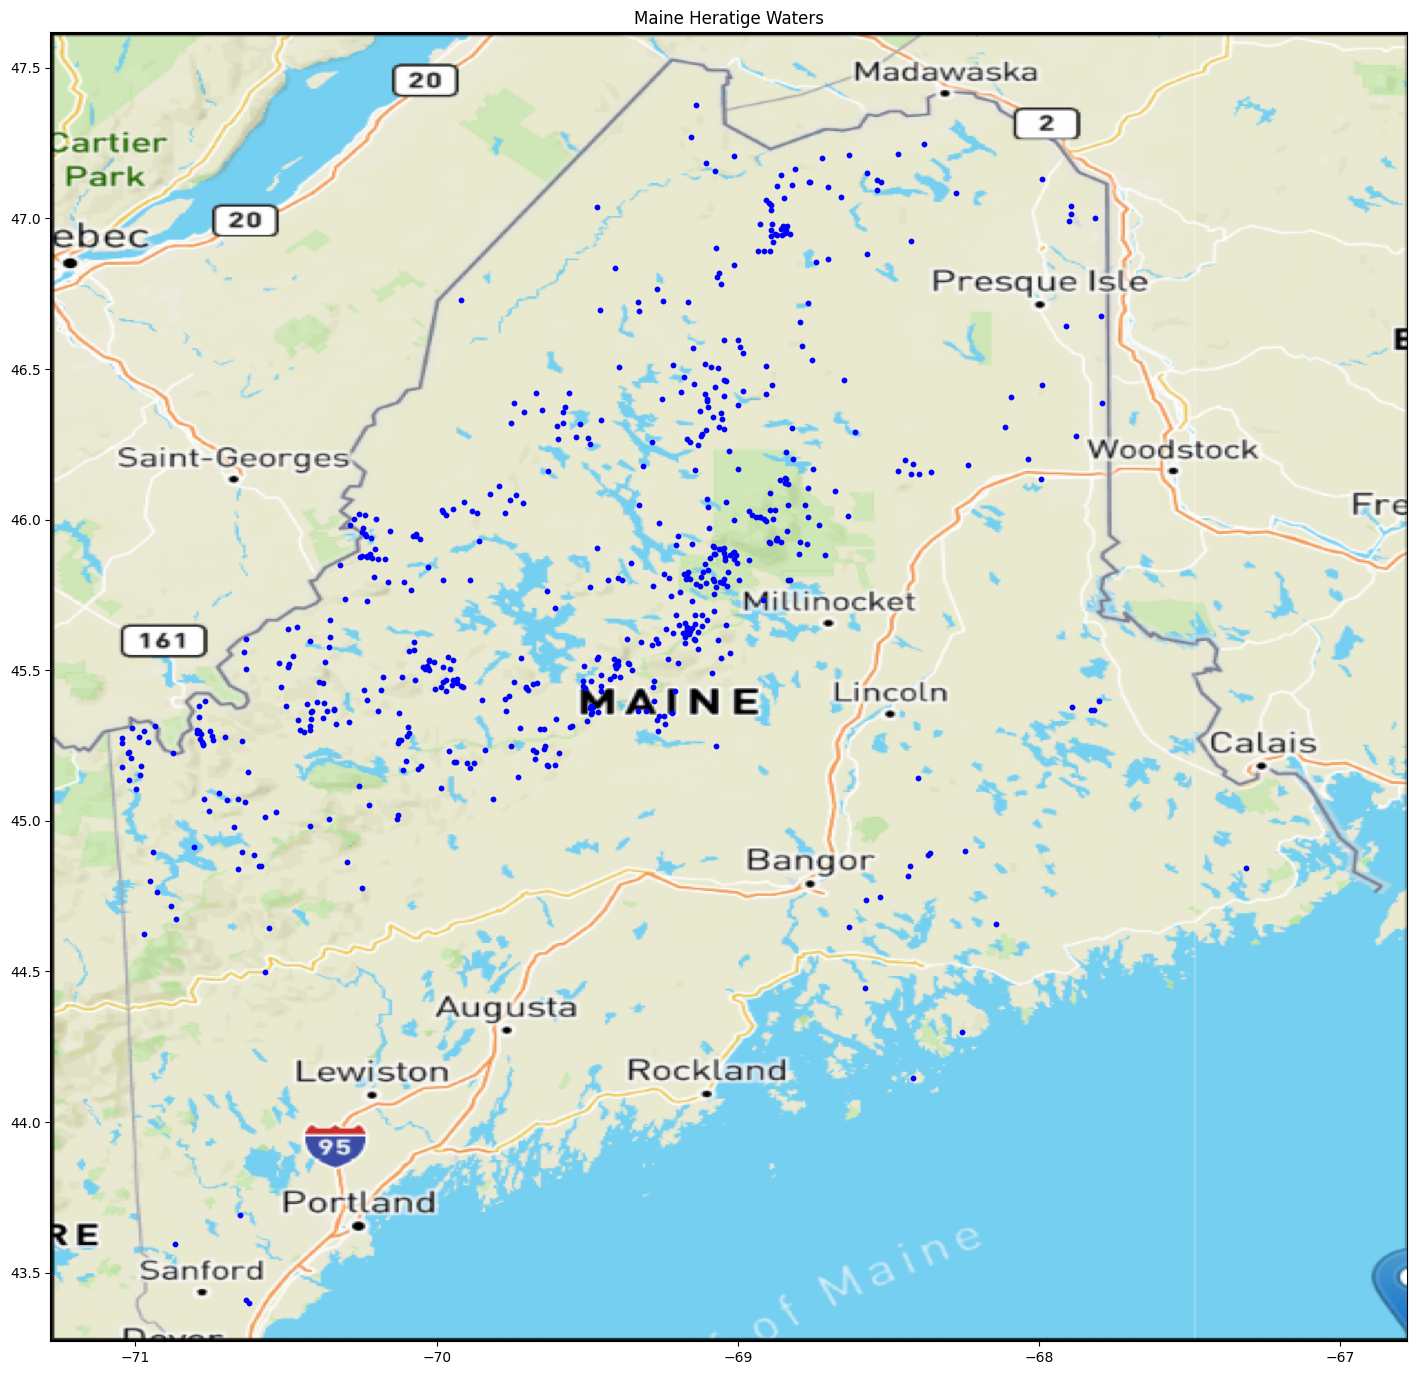

In [16]:
fig, ax = plt.subplots(figsize = (34,17))
ax.scatter(MaineTroutPondsComplete2023.Longitude, MaineTroutPondsComplete2023.Latitude, zorder=1, alpha= 1, c='b', s=10)
ax.set_title('Maine Heratige Waters')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

Now that We have a Map of all the Heritage Waters, Lets make some visualzations showing what drainages each pond is part of, and the dribution of LandLocked Atlantic Salmon.

<ipython-input-17-4ba687e02cb9>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = MaineTroutPondsComplete2023['Major Drainage'].replace(classes, [0,1,2,3,4,5,6,7,8,9])


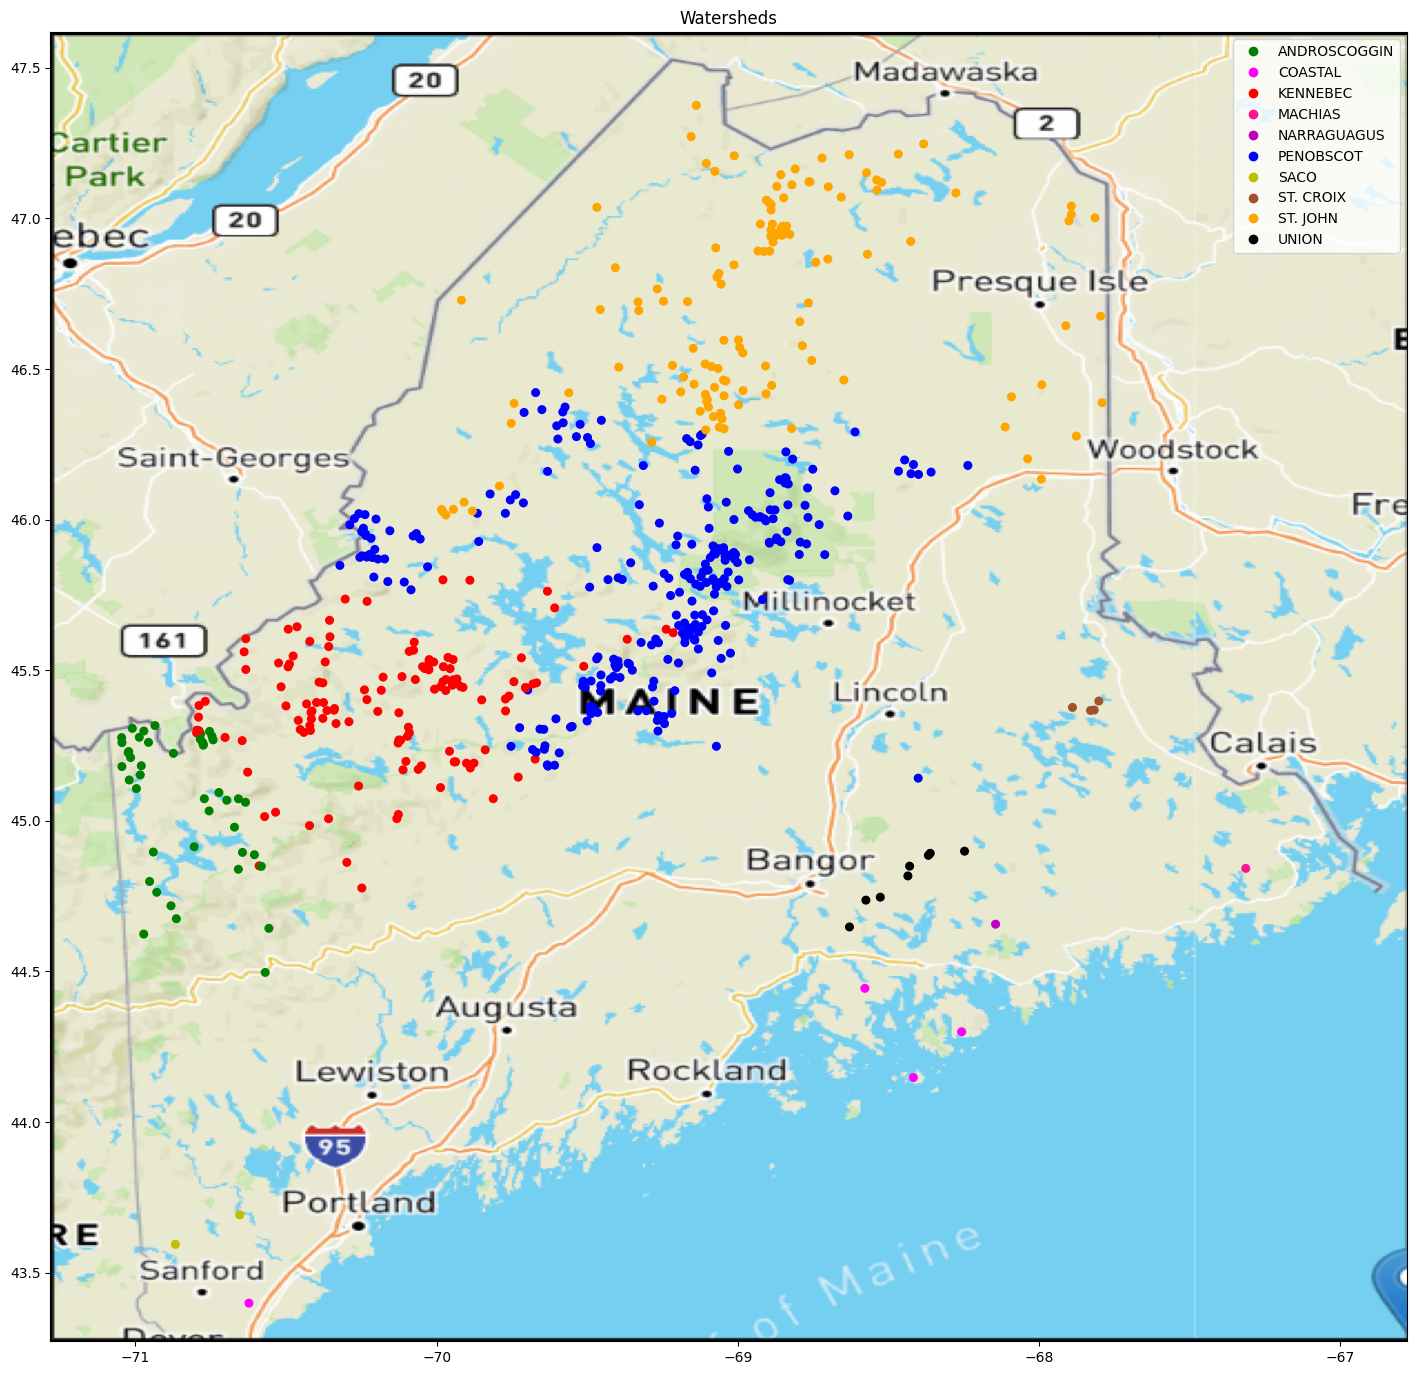

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(figsize = (34,17))
x = MaineTroutPondsComplete2023.Longitude
y = MaineTroutPondsComplete2023.Latitude
classes = sorted([d for d in MaineTroutPondsComplete2023['Major Drainage'].unique() if isinstance(d, str)])
values = MaineTroutPondsComplete2023['Major Drainage'].replace(classes, [0,1,2,3,4,5,6,7,8,9])
colors = ListedColormap(['g','fuchsia','r','deeppink','m','teal','blue','y','sienna','orange','k'])
ax.imshow(ruh_m, zorder=1, extent = BBox, aspect= 'equal')
scatter = ax.scatter(x, y, c=values, cmap=colors, zorder=2, alpha=1, s=30)
ax.set_title('Watersheds')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()


For making graphs showing the distribution of other kinds of fish, I decided to turn the other fish column into an array. This is beacuse the naming of the fish in inconsistent throughout the dataset. For example "Rainbow Smelt" are also called simply "Smelt" in come locations, and "Golden Shiners" are called simply "Shiners" in others. By breaking each invidual word into its own column we can then use words like "Smelt" or "Shiner" to accuratly select the correct bodies of water.

In [18]:
MaineTroutPondsComplete2023['OTHER FISH'] = MaineTroutPondsComplete2023['OTHER FISH'].astype(str)

In [19]:
RealStopWords = list(' ')
vectorizer = CountVectorizer(stop_words=RealStopWords)
X = vectorizer.fit_transform(MaineTroutPondsComplete2023['OTHER FISH'].tolist())
Fish_DF = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
Fish_DF['Label'] = '1'
Fish_DF

alewife  american  arctic  banded  bass  blacknose  bridled  brook  \
0          0         0       0       0     0          0        0      1   
1          0         1       0       0     0          0        0      1   
2          0         0       0       0     0          0        0      0   
3          0         0       0       0     0          0        0      0   
4          0         1       0       0     0          1        0      1   
..       ...       ...     ...     ...   ...        ...      ...    ...   
580        0         0       0       0     0          0        0      1   
581        0         0       0       1     0          1        0      1   
582        0         0       0       1     0          2        0      1   
583        0         0       0       0     0          1        0      1   
584        0         0       0       0     0          1        0      2   

     brown  bullhead  ...  stickleback  sticklebacks  sucker  sunfish  \
0        0         0  ...            0             0       0        0   
1        0         0  ...            0             0       0        0   
2        0         0  ...            0             0       0        0   
3        0         0  ...            0             0       0        0   
4        1         1  ...            0             0       1        0   
..     ...       ...  ...          ...           ...     ...      ...   
580      0         0  ...            0             0       0        0   
581      1         1  ...            1             0       2        0   
582      0         0  ...            0             0       1        0   
583      0         0  ...            0             0       0        0   
584      0         0  ...            1             0       1        0   

     threespine  trout  white  whitefish  yellow  Label  
0             0      1      0          0       0      1  
1             0      1      0          0       0      1  
2             0      0      0          0       0      1  
3             0      0      0          0       0      1  
4             0      1      1          0       0      1  
..          ...    ...    ...        ...     ...    ...  
580           0      1      0          0       0      1  
581           1      1      1          1       0      1  
582           0      1      1          0       0      1  
583           0      1      0          0       0      1  
584           0      1      1          0       0      1  

[585 rows x 60 columns]

In [20]:
Fish_DF.columns

Index(['alewife', 'american', 'arctic', 'banded', 'bass', 'blacknose',
       'bridled', 'brook', 'brown', 'bullhead', 'carps', 'chain', 'char',
       'chub', 'chubsucker', 'common', 'creek', 'cusk', 'dace', 'eel',
       'fallfish', 'fathead', 'finescale', 'fourspine', 'golden', 'killifish',
       'lake', 'landlocked', 'longnose', 'minnow', 'minnows', 'nan',
       'ninespine', 'northern', 'pearl', 'perch', 'pickerel', 'pumpkinseed',
       'rainbow', 'redbelly', 'redbreast', 'round', 'salmon', 'sculpin',
       'searun', 'shiner', 'slimy', 'smallmouth', 'smelt', 'splake',
       'stickleback', 'sticklebacks', 'sucker', 'sunfish', 'threespine',
       'trout', 'white', 'whitefish', 'yellow', 'Label'],
      dtype='object')

In [21]:
MaineTroutPondsComplete2023 = pd.concat([MaineTroutPondsComplete2023,Fish_DF],axis=1)
MaineTroutPondsComplete2023.head()


WATCODE STATE HERITAGE FISH WATER ALTERNATE NAME       TOWN  COUNTY REGION  \
0     3865               COLDWATER P            NaN  KENNEBUNK    YORK      A   
1     6969        KENNEBUNK PLAINS P            NaN  KENNEBUNK    YORK      A   
2     7614       MT ZIRCON RESERVOIR            NaN    RUMFORD  OXFORD      A   
3     5012                    SAND P            NaN  LIMINGTON    YORK      A   
4     3906                  SPICER P            NaN  SHAPLEIGH    YORK      A   

  STATE HERITAGE FISH *LAST YEAR STOCKED  \
0                 BKT               1967   
1                 BKT               1971   
2                 BKT                NRS   
3                 BKT               1974   
4                 BKT                NRS   

                                          OTHER FISH  Area (acres)  ...  \
0                   ['Golden shiner', 'Brook trout']           4.0  ...   
1   ['American eel', 'Golden shiner', 'Brook trout']           3.0  ...   
2                                                nan          19.0  ...   
3                 ['Golden shiner', 'Rainbow smelt']          12.0  ...   
4  ['Brown bullhead', 'American eel', 'White suck...          11.0  ...   

   stickleback  sticklebacks  sucker  sunfish  threespine  trout  white  \
0            0             0       0        0           0      1      0   
1            0             0       0        0           0      1      0   
2            0             0       0        0           0      0      0   
3            0             0       0        0           0      0      0   
4            0             0       1        0           0      1      1   

  whitefish  yellow  Label  
0         0       0      1  
1         0       0      1  
2         0       0      1  
3         0       0      1  
4         0       0      1  

[5 rows x 88 columns]

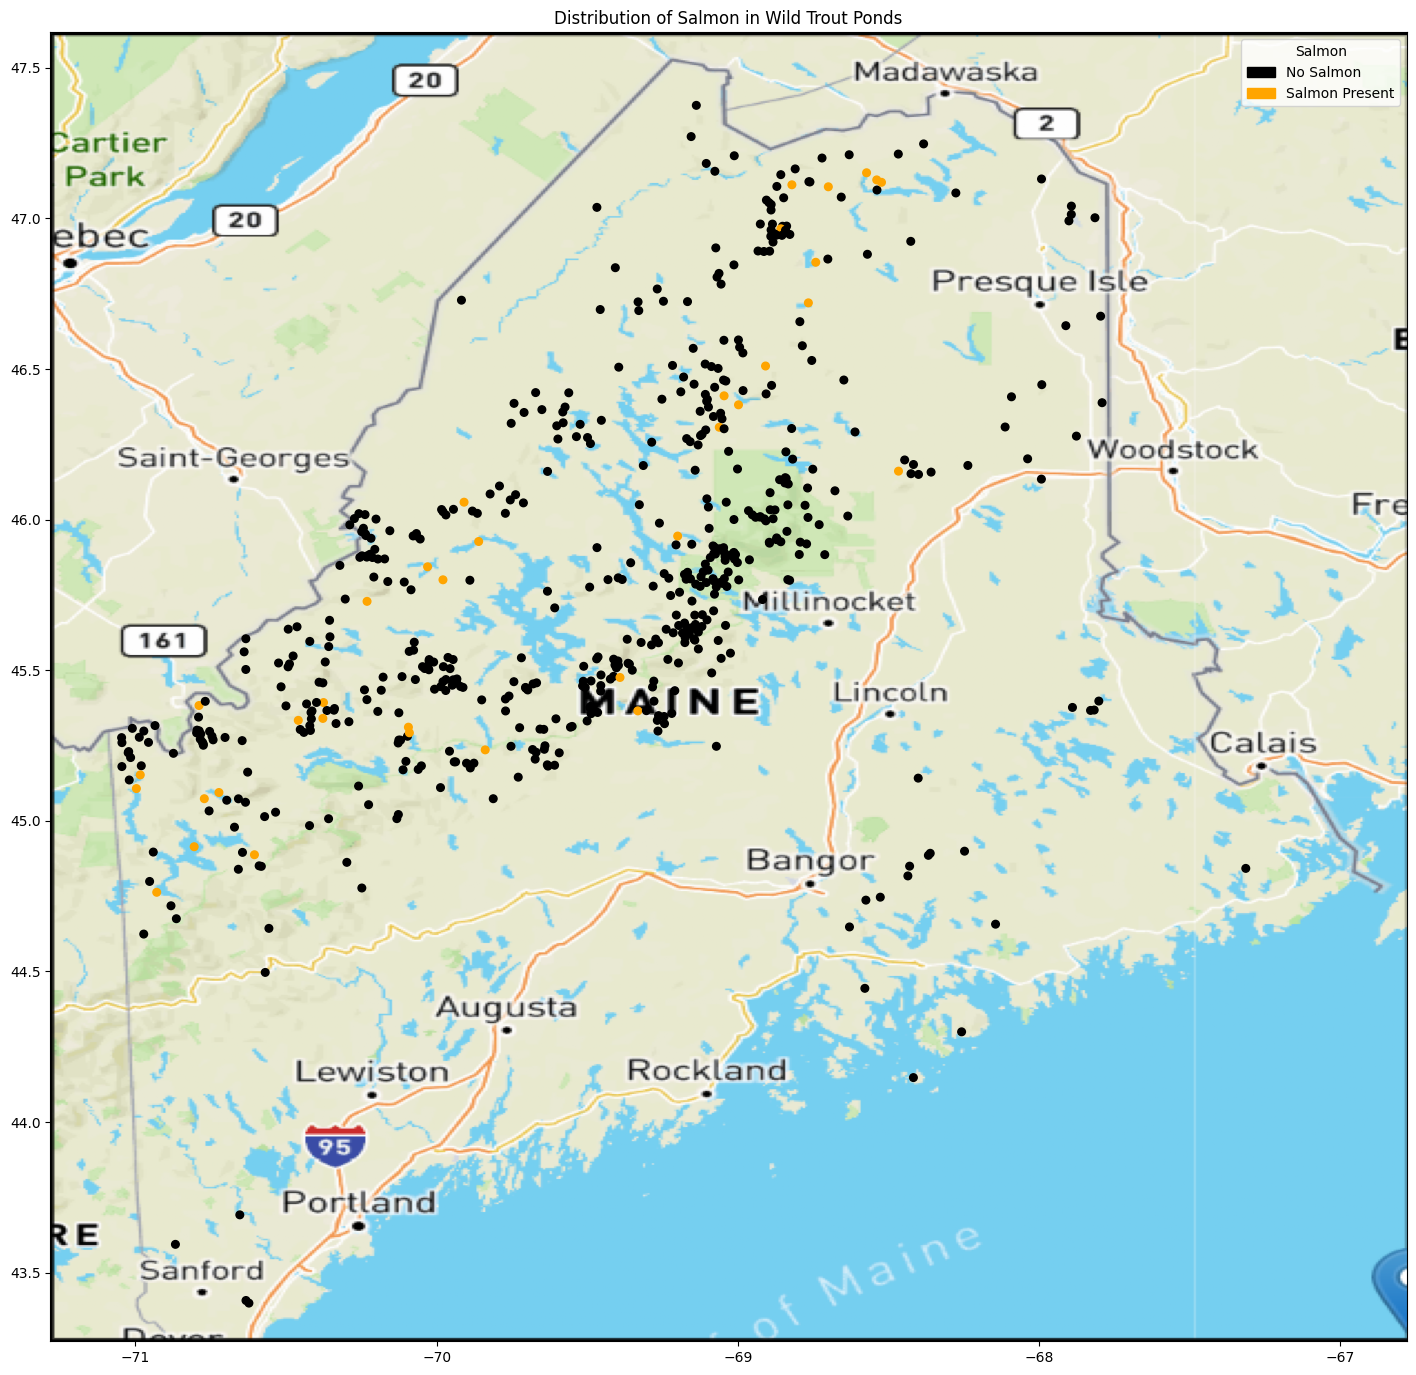

In [22]:
fig, ax = plt.subplots(figsize = (34,17))
x = MaineTroutPondsComplete2023.Longitude
y = MaineTroutPondsComplete2023.Latitude
classes = list(set(MaineTroutPondsComplete2023['salmon']))
values = MaineTroutPondsComplete2023['salmon'].astype(int).values
colors = ListedColormap(['k','orange'])
ax.imshow(ruh_m, zorder=1, extent = BBox, aspect= 'equal', alpha=1)
scatter = ax.scatter(x, y, c=values, cmap=colors, zorder=2, alpha=1, s=30)
ax.set_title('Distribution of Salmon in Wild Trout Ponds')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
legend_labels = ['No Salmon', 'Salmon Present']
legend_handles = [mpatches.Patch(color=colors(i), label=legend_labels[i]) for i in range(2)]
ax.legend(handles=legend_handles, title='Salmon')
plt.show()


In [23]:
ControlText = " ".join(MaineTroutPondsComplete2023['COUNTY'].astype(str).tolist())

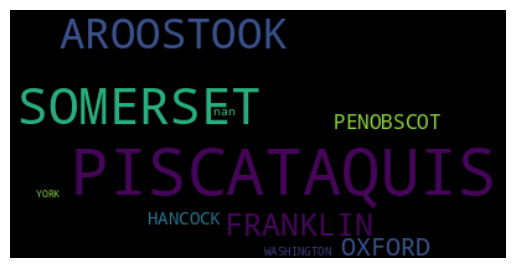

In [24]:
wordcloud = WordCloud(collocations=False).generate(ControlText)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Next I'm going to show some Machine learing I've done with this dataset. I wanted to build a model that could predict the Length Weight and Population Density of trout in specific ponds. This presented many chanllenges and required me to do lots of reading on the Biology and fishery managment of Brook Trout so I could Understand the data and exactly what was important and why. Addtionally, due to an extreme lack of training data I had to utalize Leave One Out (LOO) test train split to maximize the utiltiy of the limited data set.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np


In [2]:
# upload Maine_BKT_training_data.xlsb.xlsx
from google.colab import files
upload = files.upload()

Saving Maine_BKT_training_data.xlsb.xlsx to Maine_BKT_training_data.xlsb.xlsx


In [3]:
df = pd.read_excel('Maine_BKT_training_data.xlsb.xlsx', engine='openpyxl')
df.head(1)

WATCODE    NAME  ALTERNATE         TOWN       COUNTY REGION  \
0      478  B POND        NaN  TB R11 WELS  PISCATAQUIS      F   

  STATE HERITAGE FISH *LAST YEAR STOCKED  \
0                 BKT               1978   

                                #of other spices  Area (acres)  ...  \
0  Eel,\nWhite sucker,\nLake chub, Golden shiner           610  ...   

   Comp Value  BKT biomass  Adjsted Comp Value  AGE V Length (mm)  \
0        24.3         50.0               12.15                399   

   Fish Per Acer AGE V Weight Imputed Bio Mass  Imputed FPA  Imputed Length  \
0           1.11          623                0            0               2   

   Imputed Weight  
0               2  

[1 rows x 30 columns]

In [4]:
def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)
    data[data > upper_limit] = upper_limit
    data[data < lower_limit] = lower_limit

    return data

Due to the small size of this data set I decided to remove the outliers to minimize skewing of the data. Then I made a few visualizations to help in my feature selection.

In [5]:
Y = ['AGE V Length (mm)', 'Fish Per Acer','AGE V Weight']
Cont_vars = df.select_dtypes(include=['int64','float64'])
y_vars = df[Y]
X_vars = Cont_vars.drop(['WATCODE', 'ALTERNATE', 'AGE V Length (mm)', 'Fish Per Acer','AGE V Weight', 'Imputed Bio Mass','Imputed FPA', 'Imputed Length', 'Imputed Weight'], axis = 1)

In [6]:
y_vars = remove_outliers(y_vars)

<ipython-input-4-47d6758d09e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data > upper_limit] = upper_limit
<ipython-input-4-47d6758d09e3>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1323.9950000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data[data > upper_limit] = upper_limit
<ipython-input-4-47d6758d09e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data > upper_limit] = upper_limit
<ipython-input-4-47d

In [7]:
Targets = y_vars.columns
Features = X_vars.columns

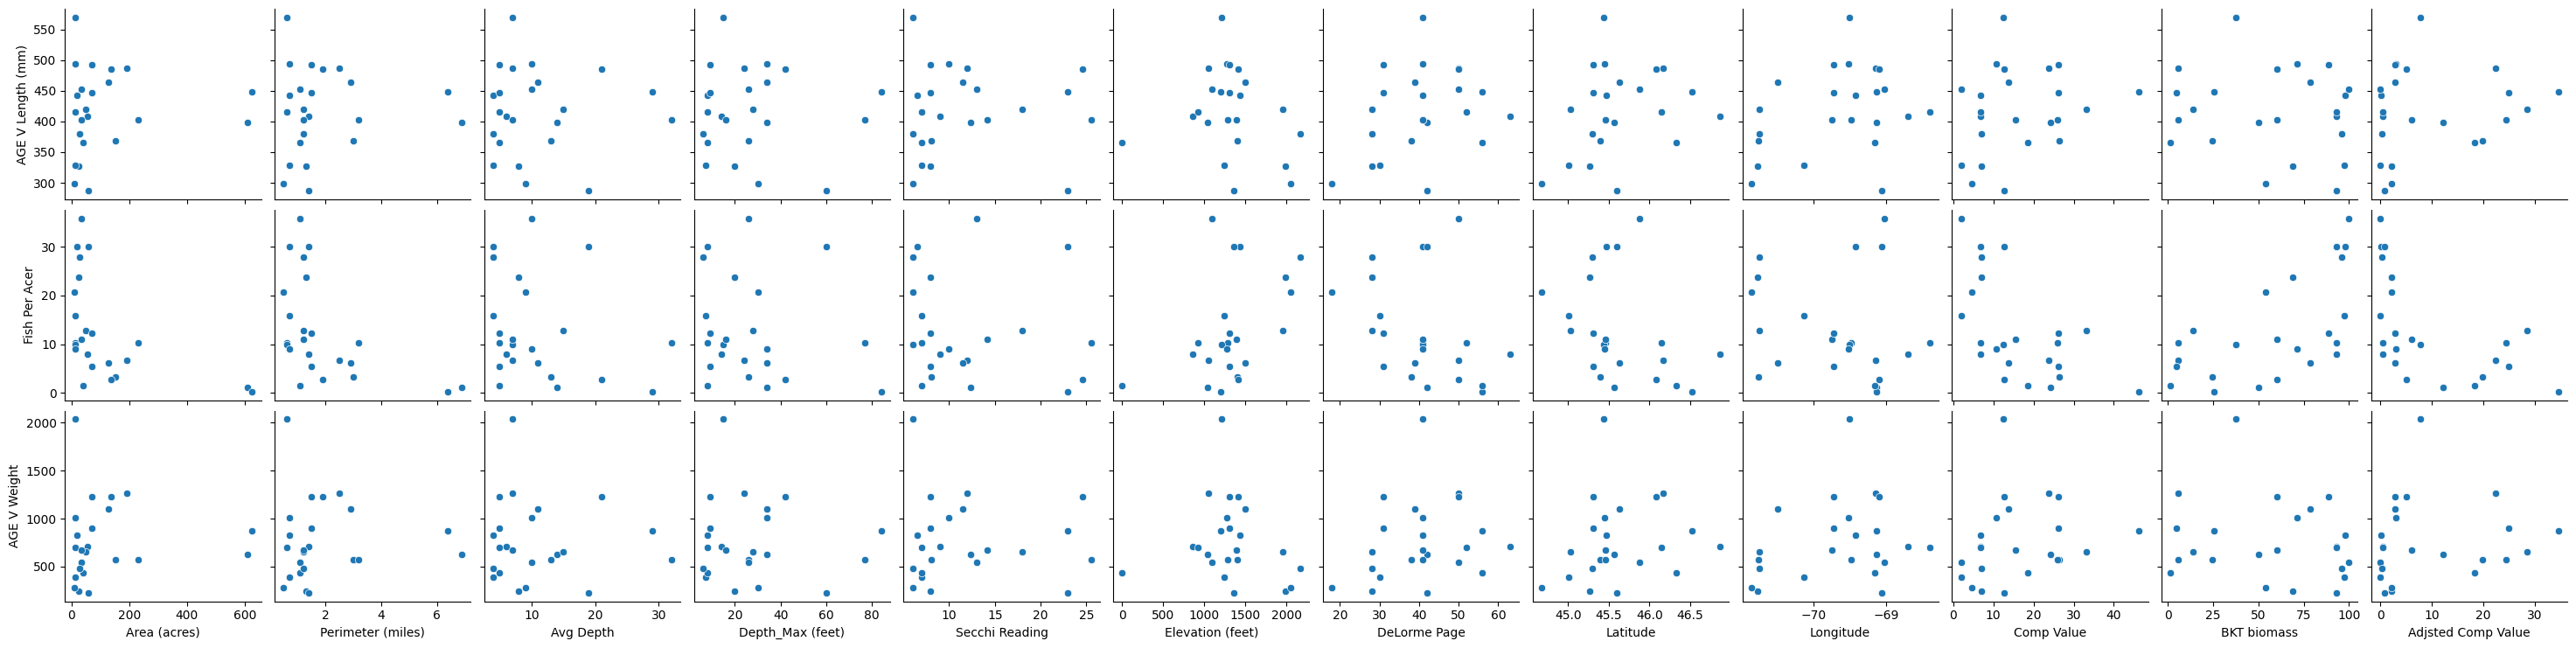

In [8]:
sns.pairplot(df, x_vars=Features, y_vars=Targets)
plt.show()

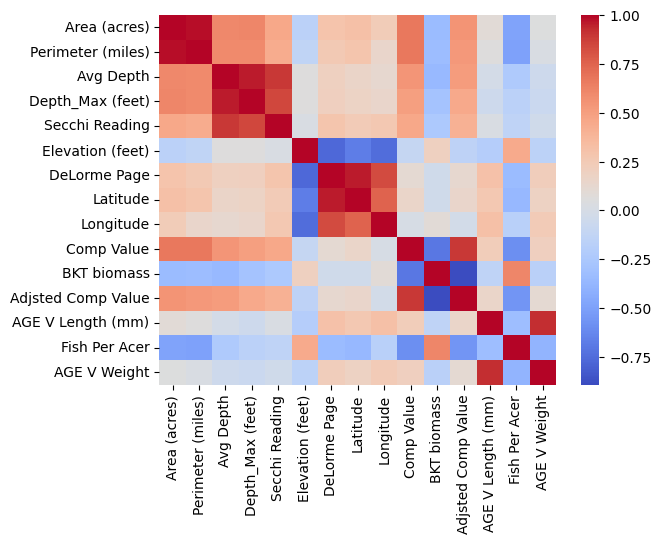

In [9]:
Cont_vars = Cont_vars.drop(['WATCODE', 'ALTERNATE', 'Imputed Bio Mass','Imputed FPA', 'Imputed Length', 'Imputed Weight'], axis = 1)
corr_matrix = Cont_vars.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot_kws={"fontsize":9})
plt.show()

Because I am trying to model three different variables, I planed on testing three diffrent feature sets with the goal of making a feature set for each to maximize accuracy across the board.

In [44]:
y1 = y_vars['AGE V Length (mm)']
y2 = y_vars['AGE V Weight']
y3 = y_vars['Fish Per Acer']

X1 = X_vars.drop(['Perimeter (miles)','Avg Depth','Secchi Reading','Adjsted Comp Value','BKT biomass','Elevation (feet)','DeLorme Page','Latitude','Longitude','Area (acres)'], axis = 1)
X2 = X_vars.drop(['Perimeter (miles)','Depth_Max (feet)','Secchi Reading','Adjsted Comp Value','DeLorme Page','Latitude','Longitude','BKT biomass','Area (acres)','Elevation (feet)'], axis = 1)
X3 = X_vars.drop(['Perimeter (miles)','Secchi Reading','Depth_Max (feet)','DeLorme Page','Comp Value','Latitude','Longitude','Area (acres)','BKT biomass','Elevation (feet)'], axis = 1)

In [45]:
X1.columns

Index(['Depth_Max (feet)', 'Comp Value'], dtype='object')

In [47]:
X2.columns

Index(['Avg Depth', 'Comp Value'], dtype='object')

In [46]:
X3.columns

Index(['Avg Depth', 'Adjsted Comp Value'], dtype='object')

In [48]:
xy_pairs = [(X1, y1), (X1, y2), (X1, y3), (X2, y1), (X2, y2), (X2, y3), (X3, y1), (X3, y2),(X3, y3)]

I tried many model types and ultimatly landed on KNN. This is because KNN preformed well and consitently where as other models would give erratic results from small changes.

In [49]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
for pair in xy_pairs:
  X, y = pair
  rmse_scores = []

  X, y = pair
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
  model = KNeighborsRegressor(n_neighbors=3) # create a KNN model with 3 neighbors
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
  print('RMSE (LOOCV) : ', round(np.mean(rmse_scores), 4))

RMSE (LOOCV) :  53.6701
RMSE (LOOCV) :  286.075
RMSE (LOOCV) :  4.6976
RMSE (LOOCV) :  50.5514
RMSE (LOOCV) :  214.2185
RMSE (LOOCV) :  6.1655
RMSE (LOOCV) :  55.784
RMSE (LOOCV) :  222.0792
RMSE (LOOCV) :  6.3029


Analysis and conclusion: The data set is too small to use more than two features at any one time. three or more features causes static in the model and hurts performance.  

Best features for length and weight predictions were the same. Average pond depth and Competions value being the best predictors. These make sense because the depth of of a pond directly impacts how much of it's bottom is exposed to sunlight allowing for aquatic plants to make the base of the boos chain. Addtionally the competion value makes sense for these metrics because competion for food and space can have negative consequences for trout growth.

Fish per acre or fish density was best predicted by depth and competion. These factors make sense again because trout require cool water to survive the hot summer months. The deeper a pond is the more cool water is available. competion reduces the survival rate of young trout through predation and competion for resources.

In conclusion machine learnig does show promise in fisheries managment applications. In the future should more data become available I would love to expand this data set to see if further improvemnts in accuracy can be made, and maybe even include addional features should enough data be made available.